In [3]:
import pickle
import glob
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import pandas as pd

In [4]:
idx_tups = []
for file in glob.glob("../../data/purchase/purchase_m*"):
    f = pickle.load(open(file, 'rb'))
    accs = []
    advs = []
    merlin_advs = []
    print(len(f), file)
    for fd in f:
        a, y, m =  max([(a, yt - yf, mt  - mf) for a, yt, yf, mt, mf in zip(fd['acc'], fd['yeom_tpr'], fd['yeom_fpr'], fd['merlin_tpr'], fd['merlin_fpr'])]) #[-1]
        fd['acc'] = a
        fd['adv'] = y
        fd['merlin_adv'] = m
        accs.append(a)
        advs.append(y)
        merlin_advs.append(m)

    
    var = file.split("_")[-5:]
    if var[-5] == 'mb':
        var[-5] = 'dp'
    else:
        var[-5] = 'is'
    var[-4] = int(var[-4])
    var[-1] = int(var[-1].split(".")[0])
    var[-3] = int(var[-3])
    var[-2] = float(var[-2]) if var[-2] != 'False' else False
    
    var.append(np.mean(accs))
    var.append(np.mean(advs))
    var.append(np.mean(merlin_advs))
    var.append(np.std(accs))
    var.append(np.std(advs))
    var.append(np.std(merlin_advs))
    # IDX tups follow the format (epsilon, throw out threshold, batch size)
    idx_tups.append(var)

5 ../../data/purchase/purchase_mb_256_100000_0.1_64.b
5 ../../data/purchase/purchase_m_256_1000_5_64.b
5 ../../data/purchase/purchase_mb_256_100000_0.5_64.b
5 ../../data/purchase/purchase_m_256_10000_0_64.b
5 ../../data/purchase/purchase_mb_256_1000000_0.5_64.b
5 ../../data/purchase/purchase_mb_256_1000000_0.1_64.b
5 ../../data/purchase/purchase_m_256_10000_5_64.b
5 ../../data/purchase/purchase_m_256_0_0_64.b
5 ../../data/purchase/purchase_mb_256_10000_0.1_64.b
5 ../../data/purchase/purchase_m_256_100000_5_64.b
5 ../../data/purchase/purchase_m_256_10000_10_64.b
5 ../../data/purchase/purchase_m_256_50000_10_64.b
5 ../../data/purchase/purchase_m_256_1000_0_64.b
5 ../../data/purchase/purchase_m_256_1000_10_64.b
5 ../../data/purchase/purchase_m_256_50000_0_64.b
5 ../../data/purchase/purchase_m_256_100000_10_64.b
5 ../../data/purchase/purchase_m_256_100000_0_64.b
5 ../../data/purchase/purchase_mb_256_10000_0.5_64.b
5 ../../data/purchase/purchase_m_256_50000_5_64.b


In [5]:
ds = pd.DataFrame(idx_tups)
ds.columns = ['method','width', 'epsilon', 'throw out', 'batch_size', 'acc', 'yeom', 'merlin', 'acc_std', 'yeom_std', 'merlin_std']

In [6]:
def plot_noise_results(df, base=None, title="", ax1 = None):
    epsilons = df['epsilon']
    acc = df['acc']
    acc_std = df['acc_std']
    adv = df['yeom']
    adv_std = df['yeom_std']
    
    if base is not None:
        base_acc = [float(base['acc']) for i in epsilons]    
        base_acc_std = [float(base['acc_std']) for i in epsilons]
        base_adv = [float(base['yeom']) for i in epsilons]
        base_adv_std = [float(base['yeom_std']) for i in epsilons]
    plt.figure()

    if ax1 is None:
        ax1 = plt.gca()
        
    markers, caps, bars = ax1.errorbar(epsilons, 
                                       acc, 
                                       acc_std, 
                                       color='b', 
                                       alpha=.8)
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    ax1.set_ylabel('Accuracy', color='b')
    ax1.tick_params('x', colors='b')
    
    if base is not None:
            markers, caps, bars = ax1.errorbar(epsilons, 
                                       base_acc, 
                                       base_acc_std, 
                                       fmt='--',
                                       color='b', 
                                       alpha=.8)
            [bar.set_alpha(0.25) for bar in bars]
            [cap.set_alpha(0.25) for cap in caps]

    ax2 = ax1.twinx()
    markers, caps, bars = ax2.errorbar(epsilons, 
                                       adv, 
                                       adv_std, 
                                       color='r')
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    ax2.set_ylabel('Membership Inference Adv', color='r')
    ax2.tick_params('x', colors='r')
    
    if base is not None:
            markers, caps, bars = ax2.errorbar(epsilons, 
                                       base_adv, 
                                       base_adv_std,
                                       fmt='--',
                                       color='r', 
                                       alpha=.8)
            [bar.set_alpha(0.25) for bar in bars]
            [cap.set_alpha(0.25) for cap in caps]

    ax1.set_xlabel('Epsilon (delta = 1e-5)')
    ax1.set_title(title)
    #fig.tight_layout()
    
    plt.xscale('log')
    return ax1, ax2
    #plt.show() 
    
def plot_against_eps(isd, dpd, arg, base=None, title="", ax1 = None):
    is_eps = isd['epsilon']
    dp_eps = dpd['epsilon']
    is_eps = [i/max(is_eps) for i in is_eps]
    dp_eps = [i/max(dp_eps) for i in dp_eps]
    is_arg = isd[arg]
    dp_arg = dpd[arg]
    is_std = isd[f'{arg}_std']
    dp_std = dpd[f'{arg}_std']
    
    if base is not None:
        base_arg = [float(base[arg]) for i in is_eps]    
        base_std = [float(base[f'{arg}_std']) for i in is_eps]
        
    markers, caps, bars = ax1.errorbar(is_eps, 
                                       is_arg, 
                                       is_std, 
                                       color='r')
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    
    markers, caps, bars = ax1.errorbar(dp_eps, 
                                       dp_arg, 
                                       dp_std, 
                                       color='blue')
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    
    if base is not None:
        markers, caps, bars = ax1.errorbar(is_eps, 
                                    base_arg, 
                                    base_std,
                                    fmt='--',
                                    color='black', 
                                    alpha=.8)
        [bar.set_alpha(0.25) for bar in bars]
        [cap.set_alpha(0.25) for cap in caps]
        return ax1

    

In [11]:
dps = ds[(ds['method'] == 'dp') & (ds['throw out'] == .1)].sort_values('epsilon')
i0 = ds[(ds['method'] == 'is') & (ds['epsilon'] != 0) & (ds['throw out'] == 0)].sort_values('epsilon')
i5 = ds[(ds['method'] == 'is') & (ds['epsilon'] != 0) & (ds['throw out'] == 0)].sort_values('epsilon')
i10 = ds[(ds['method'] == 'is') & (ds['epsilon'] != 0) & (ds['throw out'] == 0)].sort_values('epsilon')
base = ds[ds['epsilon'] == 0]


NameError: name 'iss' is not defined

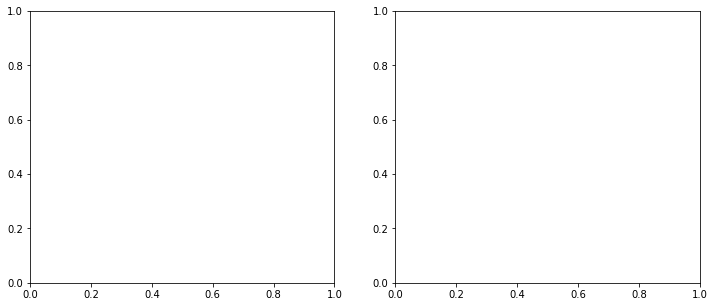

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
fig.set_size_inches(12, 5)
x1= plot_against_eps(iss, dps,'acc', base=base, title='Accuracy', ax1=ax1)
x2 = plot_against_eps(iss, dps,'yeom', base=base, title='Advantage', ax1=ax2)


Text(0.5, 1.0, 'Purchase')

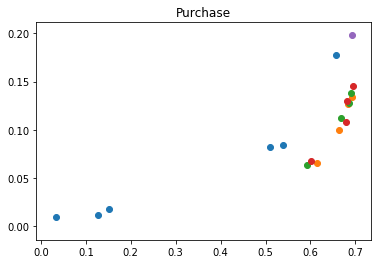

In [9]:
dps = ds[(ds['method'] == 'dp')].sort_values('acc')
i0 = ds[(ds['method'] == 'is') & (ds['epsilon'] != 0) & (ds['throw out'] == 0)].sort_values('acc')
i5 = ds[(ds['method'] == 'is') & (ds['epsilon'] != 0) & (ds['throw out'] == 5)].sort_values('acc')
i10 = ds[(ds['method'] == 'is') & (ds['epsilon'] != 0) & (ds['throw out'] == 10)].sort_values('acc')

plt.scatter(dps['acc'], dps['yeom'])
plt.scatter(i0['acc'], i0['yeom'])
plt.scatter(i5['acc'], i5['yeom'])
plt.scatter(i10['acc'], i10['yeom'])
plt.scatter(base['acc'], base['yeom'])
plt.title('Purchase')

(0.06, 0.45)

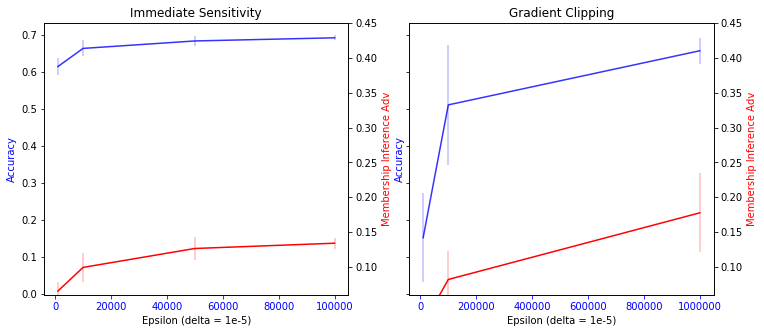

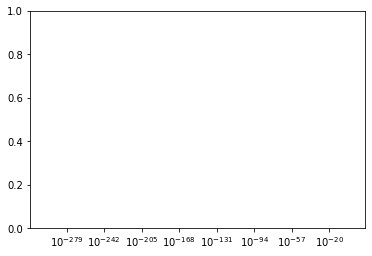

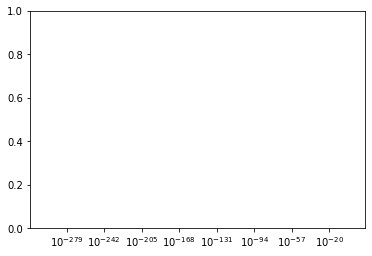

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(12, 5)
x1, x2 = plot_noise_results(i0, None, 'Immediate Sensitivity', ax1)
x3, x4 = plot_noise_results(dps, None, 'Gradient Clipping', ax2)

#x1.set_ylim(.35, .62)
#x3.set_ylim(.35, .62)
x2.set_ylim(.06, .45)
x4.set_ylim(.06, .45)